# Using pretrained models for classification

This should be everything we need to train and evaluate pretrained model performance. I was able to run this with my environment for Assignment 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [38]:
# !conda env export > environment.yml

The images need to go through the following transformations so they're of the same size and on the same scale.

In [24]:
# Define your transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Create the train, validation, and test sets. Make sure to update the path!

In [34]:
# Load the dataset
image_dataset = ImageFolder(root=r'C:\Users\jonat\Desktop\GT OMSA\CS 7643 - Deep Learning\Project\data\wikiart_subset', transform=data_transforms['train'])

# Calculate lengths for train, validation, and test sets
train_size = int(0.8 * len(image_dataset))
val_size = int(0.1 * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

# Apply different transformations to validation and test datasets
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
class_names = image_dataset.classes

Here is the distribution of each set.

In [36]:
print(f'Total images: {len(image_dataset)}')
print(f'Training images: {len(train_dataset)}')
print(f'Validation images: {len(val_dataset)}')
print(f'Test images: {len(test_dataset)}')

Total images: 9248
Training images: 7398
Validation images: 924
Test images: 926


In [31]:
# Function to get class distribution
def get_class_distribution(dataset, dataset_name):
    class_names = dataset.dataset.classes
    class_counts = {class_name: 0 for class_name in class_names}
    
    for idx in dataset.indices:
        class_idx = dataset.dataset.targets[idx]
        class_name = class_names[class_idx]
        class_counts[class_name] += 1
    
    print(f'Class distribution for {dataset_name}:')
    for class_name, count in sorted(class_counts.items(), key=lambda item: item[1], reverse=True):
        print(f'{class_name}: {count}')
    print()
    
    return class_counts

# Get class distributions
train_class_distribution = get_class_distribution(train_dataset, "Training Set")
val_class_distribution = get_class_distribution(val_dataset, "Validation Set")
test_class_distribution = get_class_distribution(test_dataset, "Test Set")

Class distribution for Training Set:
Romanticism: 313
Impressionism: 308
Mannerism_Late_Renaissance: 305
Post_Impressionism: 305
Baroque: 303
Pop_Art: 303
Art_Nouveau_Modern: 301
Minimalism: 301
Ukiyo_e: 301
Abstract_Expressionism: 300
Color_Field_Painting: 298
Naive_Art_Primitivism: 297
Realism: 297
Northern_Renaissance: 295
Early_Renaissance: 294
Cubism: 292
Pointillism: 291
Contemporary_Realism: 290
Symbolism: 289
Expressionism: 286
Rococo: 286
High_Renaissance: 282
Fauvism: 275
New_Realism: 248
Synthetic_Cubism: 168
Analytical_Cubism: 88
Action_Painting: 82

Class distribution for Validation Set:
Fauvism: 47
High_Renaissance: 45
Early_Renaissance: 44
Expressionism: 42
Pointillism: 41
Baroque: 40
Contemporary_Realism: 39
Rococo: 39
Realism: 38
Northern_Renaissance: 37
Pop_Art: 37
Abstract_Expressionism: 36
Naive_Art_Primitivism: 36
Symbolism: 36
Color_Field_Painting: 35
New_Realism: 35
Post_Impressionism: 35
Art_Nouveau_Modern: 34
Minimalism: 33
Cubism: 32
Ukiyo_e: 32
Romanticism: 3

Choose which pre-trained model you want to use. I'm currently using ResNet-50.

In [6]:
# Load a pretrained ResNet18 model
model = models.resnet50(weights="IMAGENET1K_V1")

# Modify the final layer to match the number of classes in your dataset
num_classes = len(image_dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Double check to see if you're using your GPU before training the model.

In [7]:
print(device)

cuda


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.cuda()
                labels = labels.cuda()

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the loss curves
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()

    return model

Epoch 0/9
----------


100%|██████████| 232/232 [00:53<00:00,  4.36it/s]


train Loss: 2.7830 Acc: 0.1842


100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


val Loss: 3.3535 Acc: 0.1991
Epoch 1/9
----------


100%|██████████| 232/232 [00:56<00:00,  4.12it/s]


train Loss: 2.3869 Acc: 0.2662


100%|██████████| 29/29 [00:18<00:00,  1.59it/s]


val Loss: 2.4196 Acc: 0.2619
Epoch 2/9
----------


100%|██████████| 232/232 [01:01<00:00,  3.75it/s]


train Loss: 2.1764 Acc: 0.3248


100%|██████████| 29/29 [00:17<00:00,  1.67it/s]


val Loss: 2.2678 Acc: 0.3009
Epoch 3/9
----------


100%|██████████| 232/232 [01:08<00:00,  3.40it/s]


train Loss: 2.0402 Acc: 0.3547


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


val Loss: 2.2318 Acc: 0.3203
Epoch 4/9
----------


100%|██████████| 232/232 [01:05<00:00,  3.57it/s]


train Loss: 1.8820 Acc: 0.4006


100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


val Loss: 2.2769 Acc: 0.3139
Epoch 5/9
----------


100%|██████████| 232/232 [01:02<00:00,  3.70it/s]


train Loss: 1.7643 Acc: 0.4325


100%|██████████| 29/29 [00:16<00:00,  1.71it/s]


val Loss: 2.2733 Acc: 0.3279
Epoch 6/9
----------


100%|██████████| 232/232 [00:57<00:00,  4.06it/s]


train Loss: 1.6854 Acc: 0.4557


100%|██████████| 29/29 [00:17<00:00,  1.70it/s]


val Loss: 2.0528 Acc: 0.3680
Epoch 7/9
----------


100%|██████████| 232/232 [00:52<00:00,  4.40it/s]


train Loss: 1.4721 Acc: 0.5168


100%|██████████| 29/29 [00:16<00:00,  1.72it/s]


val Loss: 2.2646 Acc: 0.3615
Epoch 8/9
----------


100%|██████████| 232/232 [00:53<00:00,  4.32it/s]


train Loss: 1.2666 Acc: 0.5816


100%|██████████| 29/29 [00:17<00:00,  1.69it/s]


val Loss: 2.2702 Acc: 0.3333
Epoch 9/9
----------


100%|██████████| 232/232 [00:53<00:00,  4.34it/s]


train Loss: 1.0590 Acc: 0.6563


100%|██████████| 29/29 [00:17<00:00,  1.70it/s]

val Loss: 2.3819 Acc: 0.3517
Best val Acc: 0.3680


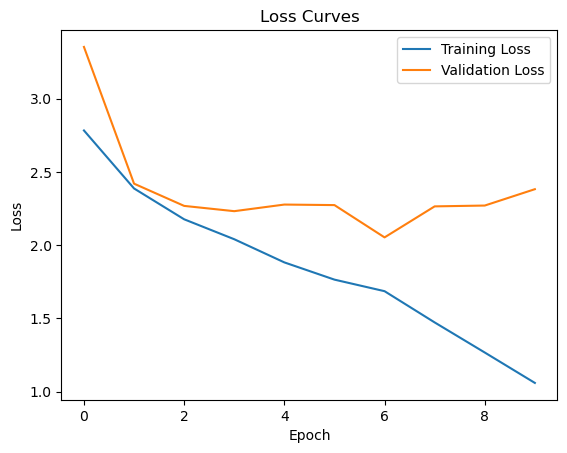

In [10]:
# Train the model
sample_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Evaluate the model after tuning it. You can also choose not to finetune and just try out different models to see how they perform without training.

In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    top5_correct = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            
            # Calculate top-5 accuracy
            _, top5_preds = outputs.topk(5, dim=1)
            top5_correct += (top5_preds == labels.view(-1, 1)).sum().item()
            
            total += labels.size(0)
    
    accuracy = correct / total
    top5_accuracy = top5_correct / total
    
    return accuracy, top5_accuracy

In [14]:
# Evaluate on test set
test_accuracy, test_top5_accuracy = evaluate_model(sample_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Top-5 Accuracy: {test_top5_accuracy:.4f}')

Evaluating: 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

Test Accuracy: 0.3315
Test Top-5 Accuracy: 0.7538


See predictions for the first num_images of dataloader.

In [22]:
def visualize_model(model, dataloader, class_names, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.show()
                    return

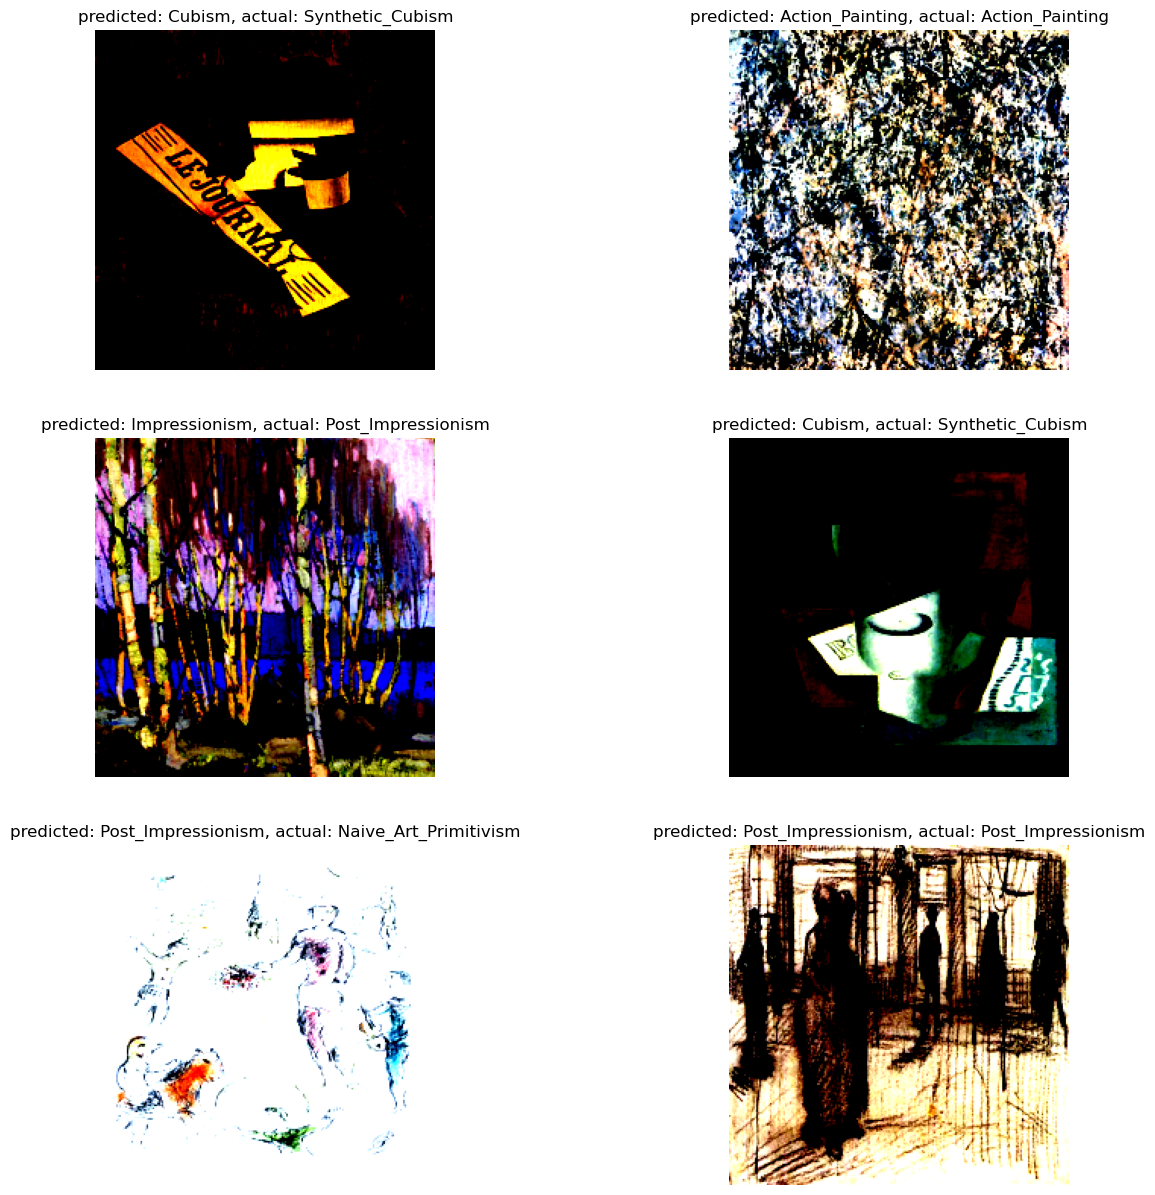

In [37]:
visualize_model(sample_model, test_loader, class_names)
plt.show()